## This is a sample Machine Learning project that exemplifies how to proceed Correspondence Analysis, Simple (SCA) and Multiple (MCA), using Python, Pandas, NumPy, SciPy, Statsmodels, Prince, Matplotlib, Seaborn and Plotly, along with Anaconda managed environments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats
import statsmodels.api as sm
import prince
import os
import plotly.graph_objects as go
import plotly.io as pio
if os.getenv("GITHUB_ACTIONS") == "true":
    pio.renderers.default = "png"
else:
    pio.renderers.default='colab'

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

## Use Case Scenario and Data - Investments' Categories per Client Profile. And a General Overview about Correspondence Analysis.

This use case shows an example of how to use Simple Correspondence Analysis (SCA), a non-supervised Machine Learning (ML) technique, to plot into a graph the categories of qualitative variables (doesn't work for quantitative variables), namely Profile (of the investor) - row variable - and Investment (predominant type) - column variable. These variables and their categories are displayed onto a contingency table, in a matrix format, that displays the multivariate frequency distribution of the variables' categories. We do not count the variables, we count each category, or class, inside each variable, and, ultimately, plot those on the perceptual map (graph). Client Profile variable has, as possible category classes: Agressive, Conservative or Moderate. While Investiment variable has, as possible category classes: Stocks, Bonds and Savings. The quantity of possible dimensions (axes) of the graph is calculated as m = min(I – 1, J – 1), being I and J the number of categories of the row and column variables. In our case, as we have 2 variables with 3 categories each, that would give us min((3-1),(3-1)) = 2. Therefore, we have a case with two dimensions, that is, with 2 eigenvalues, each one with a certain inertia, which is similar to the variance we had with Factorial Analysis, and thus represents the quantity of data distributed throughout each axis or dimension. The first dimension (or lambda 1), i.e., the X dimension, is the one with the most inertia of data represented, followed by the second dimension (or lambda 2), i.e., the Y dimension... and if there are more dimensions, the inertia drops even further. These are the dimensions (axes X and Y) of the perceptual map onto which each category "dot" will be plotted, according to their respective coordinates. The goal of this Analysis is to calculate these coordinates and finally be able to analyse if any of the row categories relates to any of the column categories, that is, if the variables are generically related and through which categories, specifically, that relation stands. The closer the categories are plotted, the closer they relate to each other, for each row and column variable. In this case, we'll have only the 2 axes X and Y (that's why it's a Simple Correspondence Analysis, and not Multiple) and 6 categories plotted at the graph, 3 for the row variable and 3 for the column variable. We wanna check if any of these relates to each other (always comparing correpondent pairs of categories, one from the row Dimension (X) and another from the column Dimension (Y))... we do not compare categories from the same dimension or axis. If Multiple Correspondence Analysis (MCA) is used (more than 2 lambdas), then we have more than 2 dimensions or variables, which is another use case at this same notebook project. The number of categories, for each dimension, could be any. For this example, we have only two dimensions or qualitative variables, with 3 categories each. 

The SCA method follows the sequence below:
- create a contingency table (crostab) with the distribution of observed frequencies of categories of each variable
- calculate and mount another table with the expected frequencies
- calculate and mount another table with the residuals, then the standardized residuals, then the adjusted standardized residuals
- calculate the Chi square statistic (partial and total)
- calculate the p-value for the Chi square statistic, in order to check if there is a statistically significant association (dependency) between the two variables. If not, do not proceed, the correspondence analysis won't be possible. If the p-value is below .05 (5%), or any other significance alfa you decide, then the qualitative variables are statistically dependent on each other. This hypothesis test is done on the Chi square distribution. Then you may proceed to check, based on what specific categories - inside the variables, that dependency of the variables is sustained
- to check what categories depend on each other, and therefore make the variables also dependent on each other, you now compare the adjusted standardized residuals, at the respective table. This hypothesis test, in turn, is done on a Z Standard Normal Distribution. For each pair of categories (one from each variable), you have that adjusted residual, and, if it's value is above 1.96 (the critical value for the hypothesis test, with a 5% significance value, at a Z Distribution), then those two categories relate to each other and, thus, contribute to the relation or dependency between their respective variables. If the variables depend on each other, it is because at least some of their categories also depend on each other. We wanna know which are those determinant categories
- now, for actually calculating the coordinates and plot the perceptual map graph, we calculate the eigenvalues, by first calculating the Matrix A, then the Matrix W. For the Matrix W we calculate the Det(W – λ . I ) = 0 equation, and finally get the absolute lambdas, one per dimension. The sum of the lambdas (inertia) is the principal total inertia. Which can also be calculated from the total Chi square. We can also calculate the relative inertia, for each lambda or dimension (the ammount of data - variance - represented at each axis)
- calculate the Mass of variables for the row variable (3 result values) and for the column variable (other 3 result variables). With these, mount the row Mass and column Mass Matrices
- now, for each lambda, we calculate its singular value
- calculate the eigenvectors for the column variable (v) and row variable (u)
- finally, and based on the respective eigenvectors, calculate the coordinates X and Y of the column and row variables' categories, plotting these on the perceptual map graph, and analyse the distance between any near categories (always one category from a variable or dimension, and another category from another variable or dimension). The usefulness of such a graph is that we can see all categories from all dimensions, all at once, on one same graph... differently from the tables we had created so far
- optionally, we can also calculate, for each observation, their average coordinates, based on the average point of their respective categories, and plot them at the perceptual map together with all categories.

For MCA, see the other .ipynb at this same project repository. Most of what we saw for SCA is the same for MCA.

In [2]:
# reading and displaying our dataset
client_financial_products = pd.read_excel("client-financial-products.xlsx")
client_financial_products

,CLIENT,PROFILE,INVESTMENT
0,Gabriela,Conservative,Savings
1,Luiz Felipe,Conservative,Savings
2,Patrícia,Conservative,Savings
3,Gustavo,Conservative,Savings
4,Letícia,Conservative,Savings
...,...,...,...
95,Sheila,Aggressive,Stocks
96,Pedro,Aggressive,Stocks
97,Horácio,Aggressive,Stocks
98,Leandro,Aggressive,Stocks


In [3]:
client_financial_products["PROFILE"].value_counts()

PROFILE
Aggressive      58
Moderate        25
Conservative    17
Name: count, dtype: int64

In [4]:
client_financial_products["INVESTMENT"].value_counts()

INVESTMENT
Stocks     45
Bonds      40
Savings    15
Name: count, dtype: int64

![contingency-table.png](contingency-table.png)

In [5]:
# creating and showing the contingency table with the two variables (and their categories)
# The two qualitative variables are: PROFILE (row) and INVESTMENT (column). PROFILE categories are: Aggressive, Conservative and 
# Moderate. INVESTMENT categories are: Bonds, Savings and Stocks.
# This table contains the absolute observed frequencies of the observations
contingency_df = pd.crosstab(client_financial_products["PROFILE"], client_financial_products["INVESTMENT"], 
                             margins=True, margins_name="TOTAL").reindex(["Aggressive","Conservative","Moderate", "TOTAL"])[["Stocks","Bonds","Savings", "TOTAL"]]
contingency_df

INVESTMENT,Stocks,Bonds,Savings,TOTAL
PROFILE,,,,
Aggressive,36,20,2,58
Conservative,5,4,8,17
Moderate,4,16,5,25
TOTAL,45,40,15,100


![expected-frequency.png](expected-frequency.png)

In [6]:
# creating aux method to reset values at dataframe
def reset_all_df_cells_to_float_nan(df):
    df = df.astype("float64")
    df.loc[:] = np.nan
    return df

In [7]:
# calculating and showing the absolute expected frequencies of the observations
expected_freq_df = contingency_df.copy()
if("TOTAL" in expected_freq_df.columns):
    expected_freq_df.drop("TOTAL",axis=1,inplace=True)    
if("TOTAL" in expected_freq_df.index):
    expected_freq_df.drop("TOTAL",axis=0,inplace=True)
expected_freq_df = reset_all_df_cells_to_float_nan(expected_freq_df)
expected_freq_df.loc["Aggressive","Stocks"] = contingency_df.loc["TOTAL","Stocks"]*contingency_df.loc["Aggressive","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Aggressive","Bonds"] = contingency_df.loc["TOTAL","Bonds"]*contingency_df.loc["Aggressive","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Aggressive","Savings"] = contingency_df.loc["TOTAL","Savings"]*contingency_df.loc["Aggressive","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Conservative","Stocks"] = contingency_df.loc["TOTAL","Stocks"]*contingency_df.loc["Conservative","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Conservative","Bonds"] = contingency_df.loc["TOTAL","Bonds"]*contingency_df.loc["Conservative","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Conservative","Savings"] = contingency_df.loc["TOTAL","Savings"]*contingency_df.loc["Conservative","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Moderate","Stocks"] = contingency_df.loc["TOTAL","Stocks"]*contingency_df.loc["Moderate","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Moderate","Bonds"] = contingency_df.loc["TOTAL","Bonds"]*contingency_df.loc["Moderate","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df.loc["Moderate","Savings"] = contingency_df.loc["TOTAL","Savings"]*contingency_df.loc["Moderate","TOTAL"]/contingency_df.loc["TOTAL","TOTAL"]
expected_freq_df

INVESTMENT,Stocks,Bonds,Savings
PROFILE,,,
Aggressive,26.10,23.2,8.70
Conservative,7.65,6.8,2.55
Moderate,11.25,10.0,3.75


![residual.png](residual.png)

In [8]:
# calculating and showing the residuals
residuals_df = contingency_df.copy()
if("TOTAL" in residuals_df.columns):
    residuals_df.drop("TOTAL",axis=1,inplace=True)    
if("TOTAL" in residuals_df.index):
    residuals_df.drop("TOTAL",axis=0,inplace=True)
residuals_df = reset_all_df_cells_to_float_nan(residuals_df)
residuals_df.loc["Aggressive","Stocks"] = contingency_df.loc["Aggressive","Stocks"]-expected_freq_df.loc["Aggressive","Stocks"]
residuals_df.loc["Aggressive","Bonds"] = contingency_df.loc["Aggressive","Bonds"]-expected_freq_df.loc["Aggressive","Bonds"]
residuals_df.loc["Aggressive","Savings"] = contingency_df.loc["Aggressive","Savings"]-expected_freq_df.loc["Aggressive","Savings"]
residuals_df.loc["Conservative","Stocks"] = contingency_df.loc["Conservative","Stocks"]-expected_freq_df.loc["Conservative","Stocks"]
residuals_df.loc["Conservative","Bonds"] = contingency_df.loc["Conservative","Bonds"]-expected_freq_df.loc["Conservative","Bonds"]
residuals_df.loc["Conservative","Savings"] = contingency_df.loc["Conservative","Savings"]-expected_freq_df.loc["Conservative","Savings"]
residuals_df.loc["Moderate","Stocks"] = contingency_df.loc["Moderate","Stocks"]-expected_freq_df.loc["Moderate","Stocks"]
residuals_df.loc["Moderate","Bonds"] = contingency_df.loc["Moderate","Bonds"]-expected_freq_df.loc["Moderate","Bonds"]
residuals_df.loc["Moderate","Savings"] = contingency_df.loc["Moderate","Savings"]-expected_freq_df.loc["Moderate","Savings"]
residuals_df

INVESTMENT,Stocks,Bonds,Savings
PROFILE,,,
Aggressive,9.90,-3.2,-6.70
Conservative,-2.65,-2.8,5.45
Moderate,-7.25,6.0,1.25


![qui-squared.png](qui-squared.png)

In [9]:
# calculating and showing manually the Chi square partials and total
chi2_df = contingency_df.copy()
if("TOTAL" in chi2_df.columns):
    chi2_df.drop("TOTAL",axis=1,inplace=True)    
if("TOTAL" in chi2_df.index):
    chi2_df.drop("TOTAL",axis=0,inplace=True)
chi2_df = reset_all_df_cells_to_float_nan(chi2_df)
chi2_df.loc["Aggressive","Stocks"] = np.square(residuals_df.loc["Aggressive","Stocks"])/expected_freq_df.loc["Aggressive","Stocks"]
chi2_df.loc["Aggressive","Bonds"] = np.square(residuals_df.loc["Aggressive","Bonds"])/expected_freq_df.loc["Aggressive","Bonds"]
chi2_df.loc["Aggressive","Savings"] = np.square(residuals_df.loc["Aggressive","Savings"])/expected_freq_df.loc["Aggressive","Savings"]
chi2_df.loc["Conservative","Stocks"] = np.square(residuals_df.loc["Conservative","Stocks"])/expected_freq_df.loc["Conservative","Stocks"]
chi2_df.loc["Conservative","Bonds"] = np.square(residuals_df.loc["Conservative","Bonds"])/expected_freq_df.loc["Conservative","Bonds"]
chi2_df.loc["Conservative","Savings"] = np.square(residuals_df.loc["Conservative","Savings"])/expected_freq_df.loc["Conservative","Savings"]
chi2_df.loc["Moderate","Stocks"] = np.square(residuals_df.loc["Moderate","Stocks"])/expected_freq_df.loc["Moderate","Stocks"]
chi2_df.loc["Moderate","Bonds"] = np.square(residuals_df.loc["Moderate","Bonds"])/expected_freq_df.loc["Moderate","Bonds"]
chi2_df.loc["Moderate","Savings"] = np.square(residuals_df.loc["Moderate","Savings"])/expected_freq_df.loc["Moderate","Savings"]
print(chi2_df)
chi2_value = chi2_df.to_numpy().sum()
print(f"\nTotal Chi square: {chi2_value}")

INVESTMENT      Stocks     Bonds    Savings
PROFILE                                    
Aggressive    3.755172  0.441379   5.159770
Conservative  0.917974  1.152941  11.648039
Moderate      4.672222  3.600000   0.416667

Total Chi square: 31.764164976335362


In [10]:
# calculating critical value for a degrees_of_freedom of (3-1)(3-1) = 4 at Chi square distribution
critical_value = stats.chi2.ppf(1-.05, df=4)
print(f"total chi square: {chi2_value} > critical value: {round(critical_value,3)}")

total chi square: 31.764164976335362 > critical value: 9.488


In [11]:
# calculating p-value for a degrees_of_freedom of (3-1)(3-1) = 4 at Chi square distribution
p_value = round(1-stats.chi2.cdf(chi2_value, 4),6)
print(f"p_value {p_value:.6f} < significance level 0.05")

p_value 0.000002 < significance level 0.05


In [12]:
print("H0 rejected. H1 confirmed ! Both because Chi square statistic > critical value, as because p-value < alfa, there IS a NOT random association between the two qualitative variables ! Now we gotta find out which categories inside the variables are responsible for that ! This way, we may proceed with the analysis !")

H0 rejected. H1 confirmed ! Both because Chi square statistic > critical value, as because p-value < alfa, there IS a NOT random association between the two qualitative variables ! Now we gotta find out which categories inside the variables are responsible for that ! This way, we may proceed with the analysis !


In [13]:
# redoing the same we did manually right above through scipy - calculating chi square, now automatically, using the libs
# we gotta drop the TOTAL edge margins before sending the contingency table to the functions below:
if("TOTAL" in contingency_df.columns):
    contingency_df.drop("TOTAL",axis=1,inplace=True)    
if("TOTAL" in contingency_df.index):
    contingency_df.drop("TOTAL",axis=0,inplace=True)
test_qui2 = chi2_contingency(contingency_df)
print(f"Chi² statistic: {round(test_qui2[0], 2)}")
print(f"p-value: {round(test_qui2[1], 6):.6f}")
print(f"degrees of freedom: {test_qui2[2]}")

Chi² statistic: 31.76
p-value: 0.000002
degrees of freedom: 4


In [14]:
# using statsmodel to calculate and extract the other statistics manually calculated before - now automatically, using the libs
contingency_stats_df = sm.stats.Table(contingency_df)

In [15]:
# extracting the absolute expected frequencies of the observations
contingency_stats_df.fittedvalues

INVESTMENT,Stocks,Bonds,Savings
PROFILE,,,
Aggressive,26.10,23.2,8.70
Conservative,7.65,6.8,2.55
Moderate,11.25,10.0,3.75


In [16]:
# calculating and showing the residuals (observed frequencies - expected frequencies)
# there's no attribute or method for getting these directly - gotta do the subtraction as below
contingency_df-contingency_stats_df.fittedvalues

INVESTMENT,Stocks,Bonds,Savings
PROFILE,,,
Aggressive,9.90,-3.2,-6.70
Conservative,-2.65,-2.8,5.45
Moderate,-7.25,6.0,1.25


In [17]:
# calculating and showing the Chi square partials and total
print(contingency_stats_df.chi2_contribs)
print(f"\nTotal Chi square: {contingency_stats_df.chi2_contribs.to_numpy().sum()}")

INVESTMENT      Stocks     Bonds    Savings
PROFILE                                    
Aggressive    3.755172  0.441379   5.159770
Conservative  0.917974  1.152941  11.648039
Moderate      4.672222  3.600000   0.416667

Total Chi square: 31.76416497633536


![residual-std.png](residual-std.png)

In [18]:
# calculating and showing the standardized residuals (residual/sq(absolute expected frequencies))
contingency_stats_df.resid_pearson

INVESTMENT,Stocks,Bonds,Savings
PROFILE,,,
Aggressive,1.937827,-0.664364,-2.271513
Conservative,-0.958110,-1.073751,3.412922
Moderate,-2.161532,1.897367,0.645497


![residual-std-adj.png](residual-std-adj.png)

In [19]:
# calculating and showing the adjusted standardized residuals (the std residuals adjusted as below)
contingency_stats_df.standardized_resids

INVESTMENT,Stocks,Bonds,Savings
PROFILE,,,
Aggressive,4.031893,-1.323444,-3.801728
Conservative,-1.418061,-1.521559,4.063291
Moderate,-3.365501,2.828427,0.808452


In [20]:
# with the adjusted standardized residuals dataframe, we may now analyse which categories, specifically, contribute to any
# association between the two variables. The hypothesis test performed above on the Chi square distribution showed that there
# is an association between the variables. We may now check which categories (inside the variables) are responsible for that.
# At the adjusted standardized residuals table, let us just check out what categories have a residuals greater than 1.96, which
# is the critical value for the hypothesis test, with a 5% significance value, at a Z Distribution. The "adjustment" on the
# standardized residuals has been exactly for letting us analyse it at a Z distribution, and test the significance of each value
# to prove the association between categories (not only between variables). While the variables' association hypothesis test is 
# done in a Chi square distribution, the categories' association hypothesis test is done in a Z distribution. That's why the
# standardized residuals must be adjusted:

# So, looking at the table above, we have residuals' values greater than 1.96 at the associations between the categories:
# - Aggressive and Stocks;
# - Conservative and Savings;
# - Moderate and Bonds.

In [21]:
# We can show this same table in a Heatmap graph:
fig = go.Figure()

maxz = np.max(contingency_stats_df.standardized_resids)+0.1
minz = np.min(contingency_stats_df.standardized_resids)-0.1

colorscale = ['skyblue' if i>1.96 else '#DEDED3' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = contingency_stats_df.standardized_resids.columns,
        y = contingency_stats_df.standardized_resids.index,
        z = np.array(contingency_stats_df.standardized_resids),
        text = contingency_stats_df.standardized_resids.values,
        texttemplate = '%{text:.2f}',
        hovertemplate=(
            'Row: %{y}<br>'
            'Column: %{x}<br>'
            'Adjusted residual (Z): %{z:.2f}<br>'
            '<extra></extra>'
        ),
        showscale = False,
        colorscale = colorscale))

fig.update_layout(
    title_text = 'Adjusted Standardized Residuals (Z Distribution)',
    title_x = 0.5,
    height = 400,
    width = 500,
    paper_bgcolor='black',
    plot_bgcolor='black',
    font=dict(color='white'),
    margin=dict(l=100, r=40, t=50, b=50)
)

fig.update_xaxes(categoryorder = 'category ascending')
fig.update_yaxes(categoryorder = 'category descending')

# adding two invisible scatter traces, that only exist to populate the legend, as there's no legend option for heatmap traces

fig.add_trace(
    go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=12, color='skyblue'),
        name='Significant (Z = adj std residual ≥ 1.96, p ≤ 0.05)',
        showlegend=True
    )
)

fig.add_trace(
    go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=12, color='#DEDED3'),
        name='Not significant',
        showlegend=True
    )
)

fig.update_layout(
    legend=dict(
        orientation='h',
        x=0.5,
        y=-0.15,
        xanchor='center',
        yanchor='top',
        bgcolor='black',
        font=dict(color='white'),
        borderwidth=0
    ),
    margin=dict(l=100, r=40, t=50, b=80)
)

fig.show()

In [22]:
# Therefore, we have a high significant association between some of these categories, which, in turn, explain the high association 
# between the two respective vabriables they compose, as a whole.
# Now we gotta put that on a perceptual map graph, by calculating the categories coordinates on that graph. 
# First, we have to calculate the A, W and Mass matrices, the eigeinvalues, the singular values and the eigenvectors (v and u) for 
# each dimension.

In [23]:
# creating ca (correspondence analysis) object for later extracting stats regarding the perceptual map
ca = prince.CA().fit(contingency_df)

![dimensions.png](dimensions.png)

In [24]:
# max number of lambdas (dimensions: X and Y => 2D perceptual Map graph)
print(f"Dimensions (number of lambda values): {min((len(contingency_df.columns)-1),(len(contingency_df.index)-1))}")

Dimensions (number of lambda values): 2


![matrix-A.png](matrix-A.png)

![matrix-W.png](matrix-W.png)

![inertia.png](inertia.png)

In [25]:
# extracting the eigenvalues, by implicitly creating the A and W matrices (from the standardized residuals), and solving the 
# Det(W – λ . I ) = 0 equation. The solving roots of the polynomial equation are the lambdas (eigenvalues) below:
eigenvalues_df = ca.eigenvalues_summary
eigenvalues_df
# this shows that 73% of the inertia (variance) is at the lambda = 0, i.e., at the X axis, while 27% is at the Y axis.

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.233,73.42%,73.42%
1,0.084,26.58%,100.00%


In [26]:
# principal total inertia (manually calculated): is the sum of lambdas, which can be manually calculated by dividing the total 
# Chi square by the N observations:
print(f"principal total inertia: {contingency_stats_df.chi2_contribs.to_numpy().sum()/len(client_financial_products)}")

principal total inertia: 0.3176416497633536


In [27]:
# principal total inertia (extracted from ca object)
ca.total_inertia_

0.3176416497633535

![mass.png](mass.png)

In [28]:
# row and column Masses of frequencies at the contingency df (manually calculated)
print(f"{contingency_df.index[0]}\t{contingency_df.iloc[0].sum()/len(client_financial_products)}")
print(f"{contingency_df.index[1]}\t{contingency_df.iloc[1].sum()/len(client_financial_products)}")
print(f"{contingency_df.index[2]}\t{contingency_df.iloc[2].sum()/len(client_financial_products)}")
print(f"\n{contingency_df.columns[0]}\t\t{contingency_df['Stocks'].sum()/len(client_financial_products):.2f}")
print(f"{contingency_df.columns[1]}\t\t{contingency_df['Bonds'].sum()/len(client_financial_products):.2f}")
print(f"{contingency_df.columns[2]}\t\t{contingency_df['Savings'].sum()/len(client_financial_products):.2f}")

Aggressive	0.58
Conservative	0.17
Moderate	0.25

Stocks		0.45
Bonds		0.40
Savings		0.15


In [29]:
# row and column Masses of frequencies at the contingency df (extracted from ca object)
print(ca.row_masses_)
print(f"\n{ca.col_masses_}")

Aggressive      0.58
Conservative    0.17
Moderate        0.25
dtype: float64

Stocks     0.45
Bonds      0.40
Savings    0.15
dtype: float64


![singular.png](singular.png)

![eigenvector.png](eigenvector.png)

In [30]:
# extracting the eigenvector for column (v). This vector, corresponds to the 3 column categories, and these values are used 
# to calculate these column categories' coordinates later at the graph. The values are calculated by substituting each lambda 
# at the W matrix, multiplying that to a column array (the column vector) and equalizing to 0. This way, we have the values
# corresponding to the 3 column categories and to their 2 dimensions (X and Y) at the graph... but these values have yet to 
# be modified to constitute the actual coordinates (see down below).
ca.svd_.V.T

array([[-0.56215025, -0.48372213],
       [ 0.09300977,  0.76899232],
       [ 0.82178847, -0.41792789]])

In [31]:
# extracting the eigenvector for row (u). This vector, corresponds to the 3 row categories, and these values are used 
# to calculate these row categories' coordinates later at the graph. The values are calculated from the v vector above, by 
# multiplying A matrix by the (vk/sigmak) of each eigenvalue (lambda) k. Sigma here is the singular value (sq(lambda)) for each k 
# eigenvalue. This way, we have the values corresponding to the 3 row categories and to their 2 dimensions (X and Y) at the 
# graph... but these values have yet to be modified to constitute the actual coordinates (see down below).
ca.svd_.U

array([[-0.62491193, -0.17171219],
       [ 0.67162481, -0.61556487],
       [ 0.39800149,  0.76915201]])

![coordinates.png](coordinates.png)

In [32]:
# extracting coordinates of row categories for the two eigenvalue dimensions (X=0 and Y=1). These coordinates are a ponderation
# of each row eigenvector value, regarding the sigma singular value (for each lambda) and the row Mass matrix (for each lambda). 
# These row categories may now be plotted at the perceptual map graph in order to be analysed with the column categories
ca.row_coordinates(contingency_df)

,0,1
PROFILE,,
Aggressive,-0.396262,-0.065513
Conservative,0.786648,-0.433800
Moderate,0.384408,0.446974


In [33]:
# extracting coordinates of column categories for the two eigenvalue dimensions (X=0 and Y=1). These coordinates are a ponderation
# of each column eigenvector value, regarding the sigma singular value (for each lambda) and the column Mass matrix (for each 
# lambda). These column categories may now be plotted at the perceptual map graph in order to be analysed with the row categories
ca.column_coordinates(contingency_df)

,0,1
INVESTMENT,,
Stocks,-0.404692,-0.209522
Bonds,0.071019,0.353291
Savings,1.024690,-0.313542


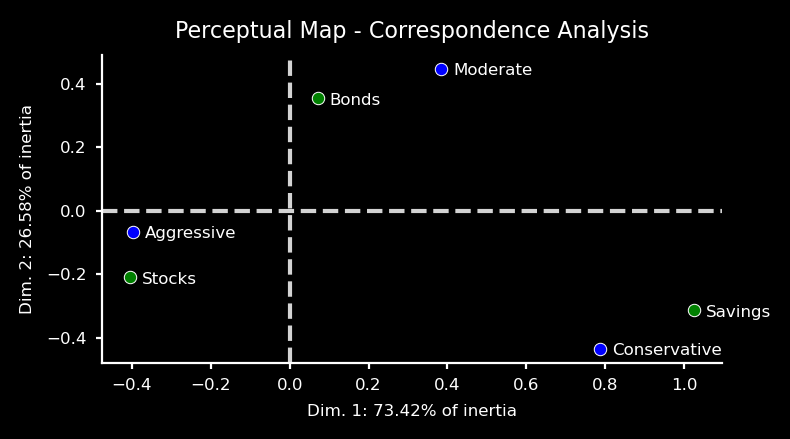

In [34]:
# Plotting row and column categories on the calculated coordinates at the perceptual map graph

chart_df_row = pd.DataFrame({'var_row': contingency_df.index,
                             'x_row': ca.row_coordinates(contingency_df)[0].values,
                             'y_row': ca.row_coordinates(contingency_df)[1].values})

chart_df_col = pd.DataFrame({'var_col': contingency_df.columns,
                             'x_col': ca.column_coordinates(contingency_df)[0].values,
                             'y_col': ca.column_coordinates(contingency_df)[1].values})

plt.figure(figsize=(4, 2), dpi=200)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=6)

label_point(x = chart_df_col['x_col'],
            y = chart_df_col['y_col'],
            val = chart_df_col['var_col'],
            ax = plt.gca())

label_point(x = chart_df_row['x_row'],
            y = chart_df_row['y_row'],
            val = chart_df_row['var_row'],
            ax = plt.gca())

sns.scatterplot(data=chart_df_row, x='x_row', y='y_row', s=20, color="blue")
sns.scatterplot(data=chart_df_col, x='x_col', y='y_col', s=20, color="green")
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--')
plt.axvline(x=0, color='lightgrey', ls='--')
plt.tick_params(size=2, labelsize=6)
plt.title("Perceptual Map - Correspondence Analysis", fontsize=8)
plt.xlabel(f"Dim. 1: {eigenvalues_df.iloc[0,1]} of inertia", fontsize=6)
plt.ylabel(f"Dim. 2: {eigenvalues_df.iloc[1,1]} of inertia", fontsize=6)
plt.show()

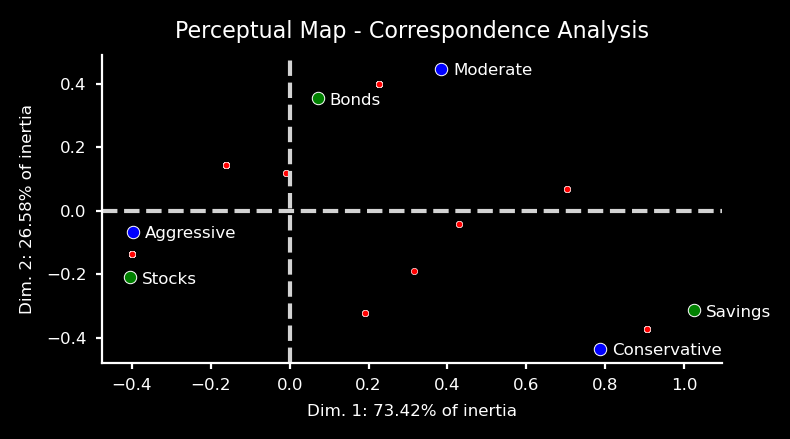

In [35]:
# We can also overlay the previous categories' perceptual map with the observations themselves. From the categories' combination
# (row and column) of each observation, we simply take the average point and plot that as a quantitative representation of the 
# qualitative data observation. Transforming qualitative into quantitative data, as such, does not generate arbitrary weighting 
# error.

# We first rename the columns from the original data df, identifying the row and column categories, then we add the categories' 
# coordinates to each corresponding observation categories' pair and finally we calculate the average coordinates to each 
# observation, as the average coordinates of the respective categories, as below:

# Identifying row and column categories (renaming original df columns)
observation_coordinates = client_financial_products.rename(columns={'PROFILE':'var_row',
                                   'INVESTMENT':'var_col'})

# Merging the calculated categories' coordinates
observation_coordinates = pd.merge(observation_coordinates, chart_df_row, how='left', on='var_row')
observation_coordinates = pd.merge(observation_coordinates, chart_df_col, how='left', on='var_col')

# Calculating the average coordinates of each observation (average coordinates of respective categories)
# Observe that the average X value of each observation is the average X value of the two respective categories, while the Y value
# of each observation is the average Y value of the same two respective categories
observation_coordinates['x_obs'] = observation_coordinates[['x_row','x_col']].mean(axis=1)
observation_coordinates['y_obs'] = observation_coordinates[['y_row','y_col']].mean(axis=1)

# Re-plotting the perceptual map (now with both categories and all observations)

chart_df_row = pd.DataFrame({'var_row': contingency_df.index,
                             'x_row': ca.row_coordinates(contingency_df)[0].values,
                             'y_row': ca.row_coordinates(contingency_df)[1].values})

chart_df_col = pd.DataFrame({'var_col': contingency_df.columns,
                             'x_col': ca.column_coordinates(contingency_df)[0].values,
                             'y_col': ca.column_coordinates(contingency_df)[1].values})

plt.figure(figsize=(4, 2), dpi=200)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=6)

label_point(x = chart_df_col['x_col'],
            y = chart_df_col['y_col'],
            val = chart_df_col['var_col'],
            ax = plt.gca())

label_point(x = chart_df_row['x_row'],
            y = chart_df_row['y_row'],
            val = chart_df_row['var_row'],
            ax = plt.gca()) 

sns.scatterplot(data=chart_df_row, x='x_row', y='y_row', s=20, color="blue")
sns.scatterplot(data=chart_df_col, x='x_col', y='y_col', s=20, color="green")
sns.scatterplot(data=observation_coordinates, x='x_obs', y='y_obs', s=5, color='red')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--')
plt.axvline(x=0, color='lightgrey', ls='--')
plt.tick_params(size=2, labelsize=6)
plt.title("Perceptual Map - Correspondence Analysis", fontsize=8)
plt.xlabel(f"Dim. 1: {eigenvalues_df.iloc[0,1]} of inertia", fontsize=6)
plt.ylabel(f"Dim. 2: {eigenvalues_df.iloc[1,1]} of inertia", fontsize=6)
plt.show()

In [36]:
# Observe, at the graph above, that, although all 100 observations have been plotted at the graph, many of them coincides with
# each other - therefore we can distinguish only a few red observation dots (many of them are overplotted). We have many 
# observations whose category discrete values are simply the same two categories, with the same category coordinates and, as such,
# the same average coordinates regarding the respective observations. When plotting data from discrete observation values, that's
# pretty much common... differently from when the original data is continuous, numeric, quantitative, already. Observe that we
# have, through this technique, not only identified the association between variables and their two-dimension categories, but 
# also transformed qualitative data - the categories' frequencies - into quantitative data - the categories' and observations' 
# numerical, quantitative, continuous coordinates... with no bias - no arbitrary weighting error.